Download and unzip the zipped folder. Open this folder in VSCode (File - Machine_learning_based_seismic_classification_for_facies_prediction - press Select Folder)

Installing the following packages (remove #). Use Python stable version 3.9.7

In [2]:
#!pip install pylops
#!pip install segysak
# pip install hyperopt
# pip install imblearn
# pip install joblib

Import necessary Python libraries

In [3]:
import segyio
from segysak.segy import segy_header_scan
from IPython.display import display

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from pylab import figure, cm
from matplotlib import colors
import plotly as px
import plotly.graph_objects as go
import plotly.express as px

In [5]:
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn import neighbors
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay
from itertools import product
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [6]:

from sklearn.linear_model import LogisticRegression

In [7]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import scipy as sp
import segyio
import pylops
import re
from IPython.display import display
from mpl_toolkits.axes_grid1 import make_axes_locatable


## I. Import custom functions

Append the folder with functions 

In [8]:
import sys
import path
sys.path.append('../Machine_learning_based_seismic_classification_for_facies_prediction/functions')

Import necessary py.files with functions

In [9]:
from segy_file_read_plot import segy_file
from plot_2D_sections import plot_2D_section, difference_map
from data_processing import replace_nonexisting_data_with_NaN, take_data_that_exist, df_wells_from_section, standartization
from machine_learning import predict_2d_RelAI_Seis_SeisInv, accuracy_score_cv, confusion_matrix_prediction, feature_importance_plot

In [55]:
from facies_features_concat import concat_features_RelAI_Seis_Envel_InstFreq_SeisInv
from machine_learning import predict_2d_RelAI_Seis_Envel_InstFreq_SeisInv, accuracy_score_cv, feature_importance_plot
from machine_learning import confusion_matrix_prediction

## I. Read segy files

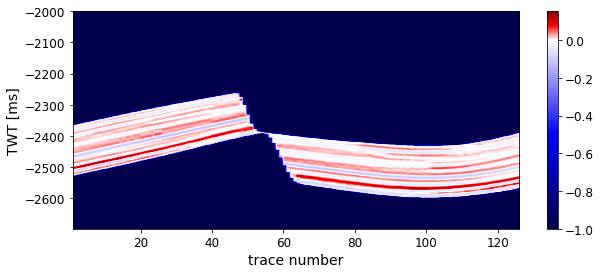

[1, 126, -2699.0, -2000.0]

In [11]:
seismic, extent_seismic = segy_file(file_name='../Machine_learning_based_seismic_classification_for_facies_prediction/case_3_files/Seismic_10_60_Fault_case3.segy', color_map='seismic')
extent_seismic

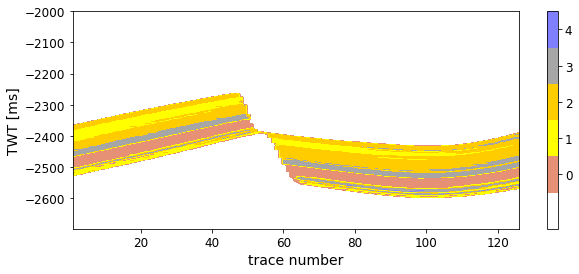

[1, 126, -2699.0, -2000.0]

In [12]:
facies, extent_facies = segy_file(file_name='../Machine_learning_based_seismic_classification_for_facies_prediction/case_3_files/Facies_Fault_case3.segy', color_map='facies')
extent_facies

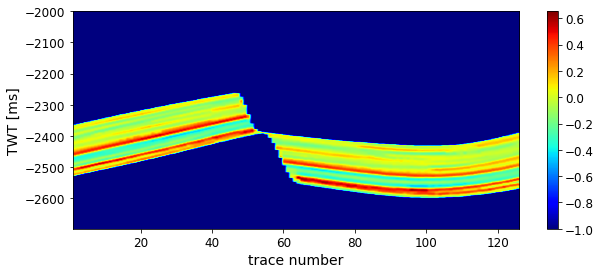

[1, 126, -2699.0, -2000.0]

In [13]:
rel_ai, extent_rel_ai = segy_file(file_name='../Machine_learning_based_seismic_classification_for_facies_prediction/case_3_files/Seismic_10_60_RelAi_Fault_case3.segy', color_map='relai')
extent_rel_ai

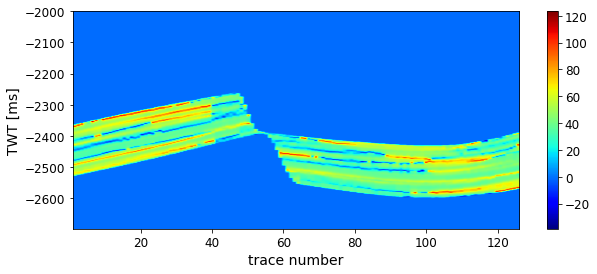

In [15]:
Inst_freq, extent_inst_freq = segy_file(file_name='../Machine_learning_based_seismic_classification_for_facies_prediction/case_3_files/InstFs_10_60_Fault_case3.segy', color_map='any')

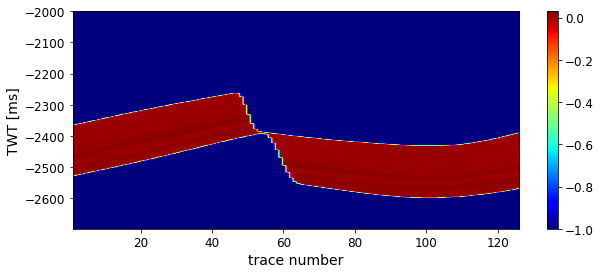

In [16]:
Envelope, extent_sweet = segy_file(file_name='../Machine_learning_based_seismic_classification_for_facies_prediction/case_3_files/Envelope_10_60_Fault_case3.segy', color_map='any')

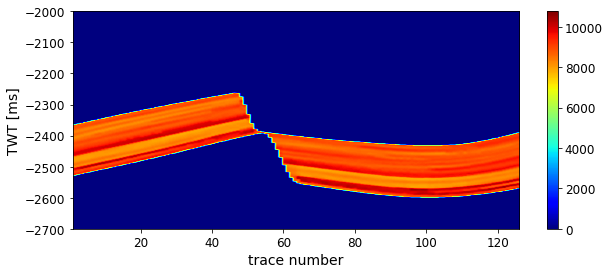

In [17]:
Seis_inv, extent_seis_inv = segy_file(file_name='../Machine_learning_based_seismic_classification_for_facies_prediction/case_3_files/Seismic_inv_10_60_Fault_case3.segy', color_map='any')

# Data processing

### Extract all data from SEGy to DataFrame

In [18]:
df_inst_freq = pd.DataFrame(Inst_freq.T)
df_envel = pd.DataFrame(Envelope.T)
df_facies = pd.DataFrame(facies.T)
df_seis = pd.DataFrame(seismic.T)
df_relai = pd.DataFrame(rel_ai.T)

df_inst_freq = df_inst_freq.iloc[0:700]
df_envel = df_envel.iloc[0:700]
df_facies = df_facies.iloc[0:700]
df_seis = df_seis.iloc[0:700]
df_relai = df_relai.iloc[0:700]

In [19]:
df_seis_inv = pd.DataFrame(Seis_inv.T)
# Cut the last row in seis inve since it has 701 rows
df_seis_inv = df_seis_inv.iloc[0:700]



## Explore data

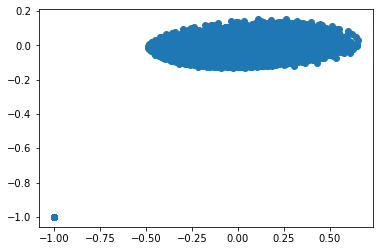

In [20]:
# Plot Rel AI VS seismic
plt.scatter(df_relai.iloc[:,:], df_seis.iloc[:,:])
plt.show()

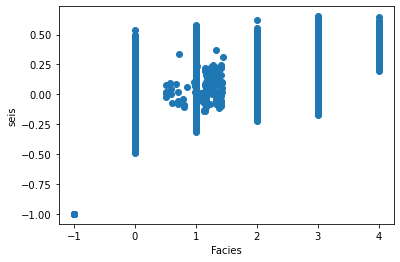

In [21]:
# Plot Facies VS Seismic
plt.scatter(df_facies, df_relai)
plt.xlabel('Facies')
plt.ylabel('seis')
plt.show()

As we can see from the plot there are noninteger values in Facies. 

To perfrom classification facies should be integers (categorical values).

So, we need to modify data. 

Facies 0 do not exist (-1.5 <= x <= -0.5)  -- then change to NaN

Facies 0 belons to (-0.5 < x <= 0.5)

Facies 1 belongs (0.5 < x <= 1.5)

Facies 2 belongs (1.5 < x <= 2.5)

Facies 3 belongs (2.5 < x <= 3)




### Filter Facies data

In [22]:
# Create facies interval as a Dictionary
interval = {'from': [-1.5, -0.5, 0.5, 1.5, 2.5, 3.5], 
'to':[-0.5, 0.5, 1.5, 2.5, 3.5, 4.5], 
'facies':[np.NaN, 0, 1, 2, 3, 4]}

# Convert dictionary to DataFrame
int_pd = pd.DataFrame.from_dict(interval)
int_pd

,from,to,facies
0,-1.5,-0.5,NaN
1,-0.5,0.5,0.0
2,0.5,1.5,1.0
3,1.5,2.5,2.0
4,2.5,3.5,3.0
5,3.5,4.5,4.0


In [23]:
intervals = int_pd.set_index(pd.IntervalIndex.from_arrays(int_pd['from'], int_pd['to'], closed='right'))['facies']
intervals

(-1.5, -0.5]    NaN
(-0.5, 0.5]     0.0
(0.5, 1.5]      1.0
(1.5, 2.5]      2.0
(2.5, 3.5]      3.0
(3.5, 4.5]      4.0
Name: facies, dtype: float64

In [24]:
# Create IntervalIndex from DataFrame
intervals = int_pd.set_index(pd.IntervalIndex.from_arrays(int_pd['from'], int_pd['to']))['facies']

# RIGHT
intervals = int_pd.set_index(pd.IntervalIndex.from_arrays(int_pd['from'], int_pd['to'], closed='right'))['facies']

# LEFT
# intervals = int_pd.set_index(pd.IntervalIndex.from_arrays(int_pd['from'], int_pd['to'], closed='left'))['facies']

df_facies = df_facies.copy()
# df_new = pd.DataFrame(index=range(len(df_f_copy.index)), columns=df_f_copy.columns)

for each_col in df_facies.columns:
    df_facies[each_col] = df_facies[each_col].map(intervals)

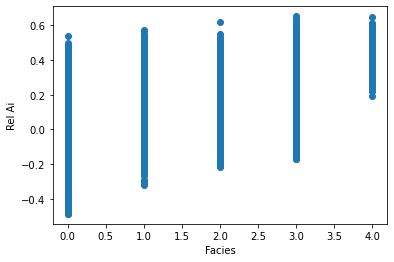

In [25]:
# Plot Facies VS Rel AI
plt.scatter(df_facies, df_relai)
plt.xlabel('Facies')
plt.ylabel('Rel Ai')
plt.show()

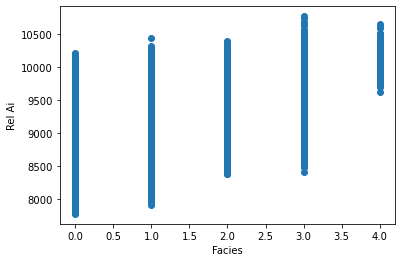

In [26]:
# Plot Facies VS Rel AI
plt.scatter(df_facies, df_seis_inv)
plt.xlabel('Facies')
plt.ylabel('Rel Ai')
plt.show()

### Remove data that are out of reservoir (for depths it is data that =250)

In [27]:
# from data_processing import replace_nonexisting_data_with_NaN, take_data_that_exist, standartization

In [28]:
df_facies.head()

,0,1,2,3,4,5,6,7,8,9,...,116,117,118,119,120,121,122,123,124,125
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
df_relai.head(2)

,0,1,2,3,4,5,6,7,8,9,...,116,117,118,119,120,121,122,123,124,125
0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [30]:
df_inst_freq.head(2)

,0,1,2,3,4,5,6,7,8,9,...,116,117,118,119,120,121,122,123,124,125
0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [31]:
df_envel.head(2)

,0,1,2,3,4,5,6,7,8,9,...,116,117,118,119,120,121,122,123,124,125
0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [32]:
df_seis.head(2)

,0,1,2,3,4,5,6,7,8,9,...,116,117,118,119,120,121,122,123,124,125
0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [33]:
df_seis_inv.head(2)

,0,1,2,3,4,5,6,7,8,9,...,116,117,118,119,120,121,122,123,124,125
0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


All data out of reservoir have values -1, so I can apply 'replace_nonexisting_data_with_NaN' function

In [34]:

df_relai = replace_nonexisting_data_with_NaN(df_relai, df_relai.iloc[0,0])
df_inst_freq = replace_nonexisting_data_with_NaN(df_inst_freq, df_inst_freq.iloc[0,0])
df_envel = replace_nonexisting_data_with_NaN(df_envel, df_envel.iloc[0,0])
df_seis = replace_nonexisting_data_with_NaN(df_seis, df_seis.iloc[0,0])

df_seis_inv = replace_nonexisting_data_with_NaN(df_seis_inv, df_seis_inv.iloc[0,0])

In [35]:
# Plot 2D

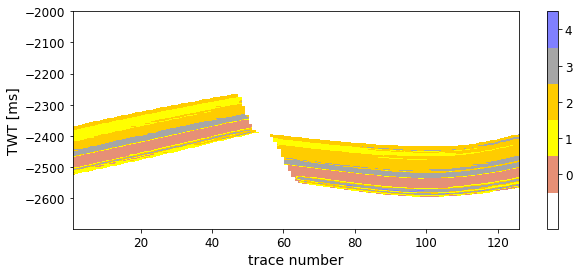

In [36]:
plot_2D_section(data_file=df_facies.T, extent_plot=extent_facies, color_map='facies', number_of_facies=5, list_of_wells=None)

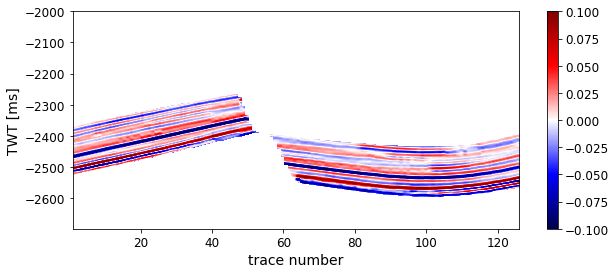

In [37]:
plot_2D_section(data_file=df_seis.T, extent_plot=extent_seismic, color_map='seismic', number_of_facies=5, list_of_wells=None)

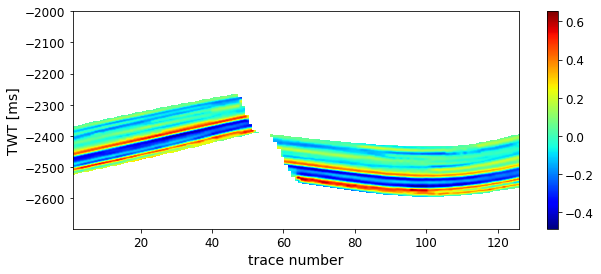

In [38]:
plot_2D_section(data_file=df_relai, extent_plot=extent_seismic, color_map='any', number_of_facies=5, list_of_wells=None)

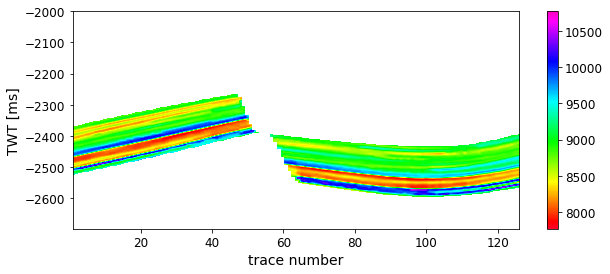

In [39]:
plot_2D_section(data_file=df_seis_inv, extent_plot=extent_seismic, color_map='seis_inv', number_of_facies=5, list_of_wells=None)

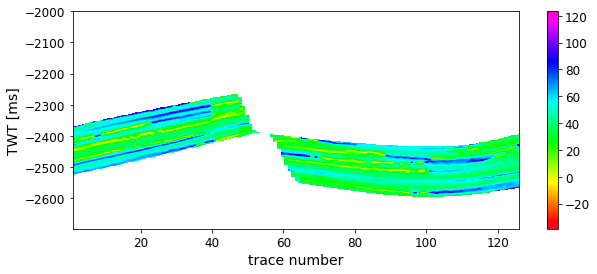

In [40]:
plot_2D_section(data_file=df_inst_freq, extent_plot=extent_seismic, color_map='seis_inv', number_of_facies=5, list_of_wells=None)

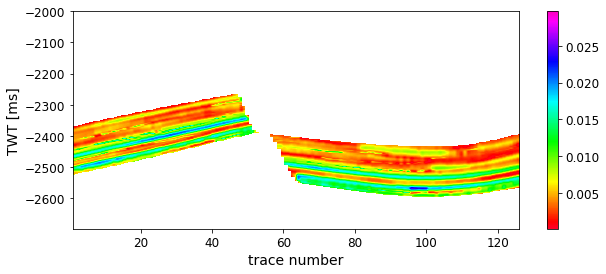

In [42]:
plot_2D_section(data_file=df_envel, extent_plot=extent_seismic, color_map='seis_inv', number_of_facies=5, list_of_wells=None)

In [43]:
df_facies.describe()

,0,1,2,3,4,5,6,7,8,9,...,116,117,118,119,120,121,122,123,124,125
count,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,165.000000,...,172.000000,173.000000,174.000000,174.000000,176.000000,177.000000,177.000000,178.000000,179.000000,179.000000
mean,1.384146,1.384146,1.371951,1.365854,1.371951,1.390244,1.371951,1.359756,1.378049,1.406061,...,1.837209,1.826590,1.821839,1.827586,1.857955,1.807910,1.774011,1.792135,1.843575,1.832402
std,0.974518,0.974518,0.985512,1.003212,0.979267,0.968917,1.016161,1.038446,1.010864,0.968384,...,1.041372,1.042129,1.062979,1.066645,1.094007,1.048454,1.089622,1.077004,1.053672,1.067845
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.750000,0.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
75%,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,...,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
max,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,4.000000,3.000000,4.000000,4.000000,4.000000,3.000000,3.000000,3.000000,3.000000,4.000000


In [44]:
df_relai.describe()

,0,1,2,3,4,5,6,7,8,9,...,116,117,118,119,120,121,122,123,124,125
count,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,165.000000,...,172.000000,173.000000,174.000000,174.000000,176.000000,177.000000,177.000000,178.000000,179.000000,179.000000
mean,0.008488,0.008295,0.009085,0.011205,0.009764,0.008374,0.009980,0.009159,0.008113,0.009362,...,0.018608,0.018752,0.017621,0.016816,0.016624,0.016967,0.016575,0.016649,0.016151,0.015623
std,0.193703,0.199015,0.211249,0.214131,0.213418,0.207357,0.208546,0.211261,0.208701,0.207130,...,0.181502,0.188715,0.183953,0.179649,0.175542,0.178945,0.178071,0.177243,0.173939,0.171842
min,-0.390706,-0.387410,-0.390597,-0.388366,-0.386494,-0.368207,-0.358709,-0.364583,-0.337937,-0.317222,...,-0.329602,-0.324528,-0.319638,-0.344292,-0.338757,-0.332212,-0.319394,-0.320985,-0.305704,-0.291122
25%,-0.112587,-0.119620,-0.116976,-0.126996,-0.128400,-0.118549,-0.125340,-0.120352,-0.122138,-0.133823,...,-0.082196,-0.085985,-0.091107,-0.096833,-0.092409,-0.096369,-0.100934,-0.091335,-0.099233,-0.087251
50%,0.009660,0.006536,-0.004472,0.004733,0.002163,-0.009384,-0.002332,-0.007791,0.001281,-0.001824,...,0.007200,-0.008203,0.001897,0.013366,0.014865,0.004210,0.010534,0.017184,0.009991,0.013249
75%,0.095143,0.090062,0.088779,0.094470,0.089413,0.089549,0.102527,0.101410,0.090670,0.097578,...,0.140787,0.142630,0.135937,0.136948,0.132422,0.134755,0.134580,0.138439,0.126182,0.130562
max,0.445175,0.488404,0.570052,0.565136,0.558625,0.558526,0.563082,0.580664,0.568985,0.549015,...,0.412782,0.476968,0.442494,0.420499,0.411785,0.474267,0.437197,0.433433,0.453079,0.451635


## Statistics


In [45]:
fig = px.histogram(df_facies.stack(), width=600, height=400, histnorm='percent', text_auto='.1f')
fig.update_layout(yaxis_title="Facies' percentage, %")
fig.update_layout(xaxis_title="Facies code")
fig.update_layout(bargap=0.2)
fig.show()

In [46]:
fig = px.histogram(df_facies.stack(), width=600, height=400,  text_auto=True)
fig.update_layout(yaxis_title="Facies' count for Zone 2")
fig.update_layout(xaxis_title="Facies code")
fig.show()

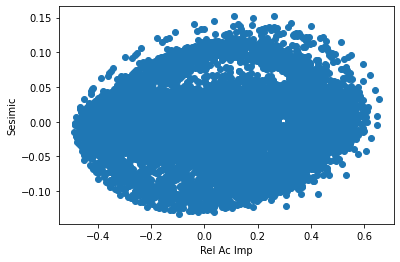

In [47]:
# Plot Rel AI VS seismic

plt.figure(figsize=(6, 4))
plt.scatter(df_relai.iloc[:,:], df_seis.iloc[:,:])
plt.xlabel('Rel Ac Imp')
plt.ylabel('Sesimic')
plt.show()

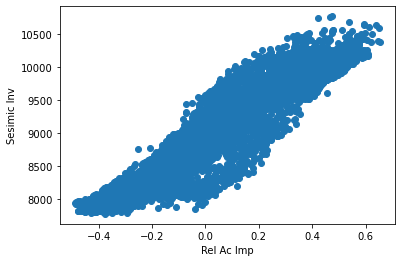

In [47]:
# Plot Rel AI VS seismic inv

plt.figure(figsize=(6, 4))
plt.scatter(df_relai.iloc[:,:], df_seis_inv.iloc[:,:])
plt.xlabel('Rel Ac Imp')
plt.ylabel('Sesimic Inv')
plt.show()

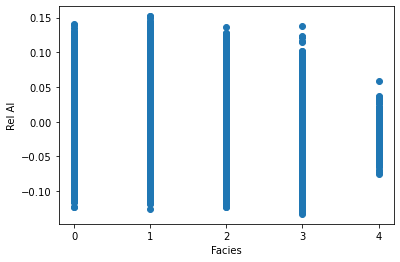

In [48]:
# Plot Facies VS Seismic
plt.scatter(df_facies, df_seis)
plt.xlabel('Facies')
plt.ylabel('Rel AI')
plt.xticks(np.arange(0, 5, 1))
plt.show()

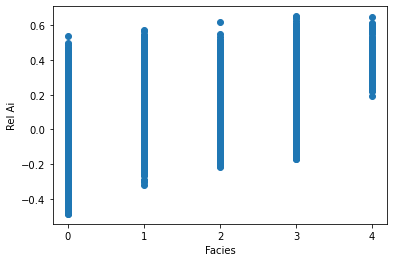

In [49]:
# Plot Facies VS Rel AI
plt.scatter(df_facies, df_relai)
plt.xlabel('Facies')
plt.ylabel('Rel Ai')
plt.xticks(np.arange(0, 5, 1))
plt.show()

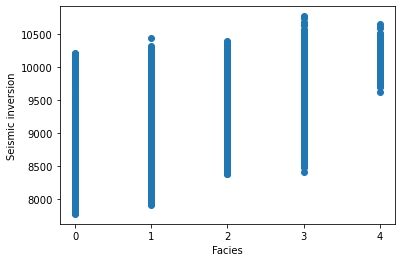

In [50]:
# Plot Facies VS Seis Inv
plt.scatter(df_facies, df_seis_inv)
plt.xlabel('Facies')
plt.ylabel('Seismic inversion')
plt.xticks(np.arange(0, 5, 1))
plt.show()

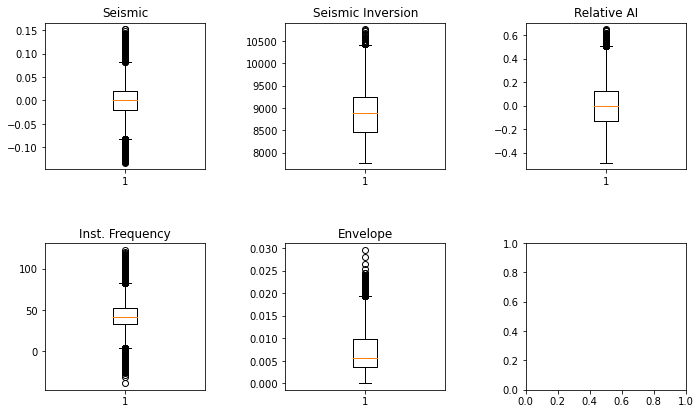

In [48]:
# Box plots


import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Polygon

fig, ax = plt.subplots(2, 3, figsize=(10, 6))
# fig, ax = plt.subplots(2, 3)

# Seismic
ax[0, 0].boxplot(df_seis.stack())
ax[0, 0].set_title('Seismic')

# Seismic Inv
ax[0, 1].boxplot(df_seis_inv.stack())
ax[0, 1].set_title('Seismic Inversion')

# Rel AI
ax[0, 2].boxplot(df_relai.stack())
ax[0, 2].set_title('Relative AI')

# Inst Freq
ax[1, 0].boxplot(df_inst_freq.stack())
ax[1, 0].set_title('Inst. Frequency')

# Envelope
ax[1, 1].boxplot(df_envel.stack())
ax[1, 1].set_title('Envelope')




fig.subplots_adjust(left=0.1, right=0.99, bottom=0.05, top=0.9,
                    hspace=0.5, wspace=0.5)



plt.show()

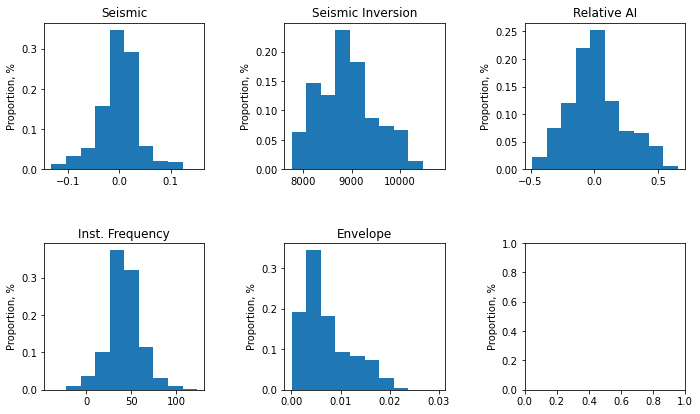

In [49]:
# Histograms


import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Polygon
from matplotlib.ticker import PercentFormatter

fig, ax = plt.subplots(2, 3, figsize=(10, 6))
# fig, ax = plt.subplots(2, 3)

# Seismic
ax[0, 0].hist(df_seis.stack(), weights=np.ones(len(df_seis.stack())) / len(df_seis.stack()))
ax[0, 0].set_title('Seismic')

# Seismic Inv
ax[0, 1].hist(df_seis_inv.stack(), weights=np.ones(len(df_seis_inv.stack())) / len(df_seis_inv.stack()))
ax[0, 1].set_title('Seismic Inversion')
#ax.flatten()[1].set_ylabel('Seismic Inv data, %')

# Rel AI
ax[0, 2].hist(df_relai.stack(), weights=np.ones(len(df_relai.stack())) / len(df_relai.stack()))
ax[0, 2].set_title('Relative AI')
#ax.flatten()[2].set_ylabel('Relative Ac Imp, %')

# Inst Freq
ax[1, 0].hist(df_inst_freq.stack(), weights=np.ones(len(df_inst_freq.stack())) / len(df_inst_freq.stack()))
ax[1, 0].set_title('Inst. Frequency')
#ax.flatten()[3].set_ylabel('Inst Frequency, %')

# Envelope
ax[1, 1].hist(df_envel.stack(), weights=np.ones(len(df_envel.stack())) / len(df_envel.stack()))
ax[1, 1].set_title('Envelope')
ax.flatten()[4].set_ylabel('Envelope, %')


for i in range(6):
    ax.flatten()[i].set_ylabel('Proportion, %')

fig.subplots_adjust(left=0.1, right=0.99, bottom=0.05, top=0.9,
                    hspace=0.5, wspace=0.5)


# plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

plt.show()

## Standartization

In [50]:
# Standartize with value_to_drop:

df_relai_std = standartization(df_relai, value_to_drop=False)
df_relai_std

df_seis_std = standartization(df_seis, value_to_drop=False)
df_seis_std

df_inst_freq_std = standartization(df_inst_freq, value_to_drop=False)
df_inst_freq_std

df_envel_std = standartization(df_envel, value_to_drop=False)
df_envel_std

df_seis_inv_std = standartization(df_seis_inv, value_to_drop=False)


# ML models 3 wells

It was defined that 3 wells is enough to reach 75% accuracy for the lower part of the reservoir

So, here, 3 random wells were chosen randomly (avoiding the fault area with no data)

In [51]:
col_3 = [40, 70, 110]

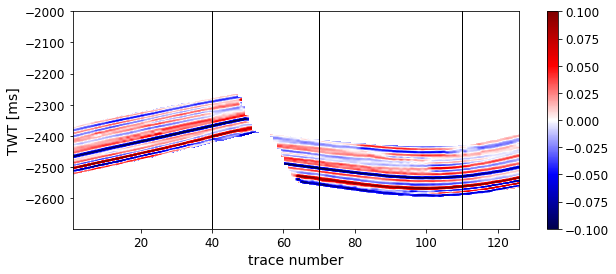

In [52]:
plot_2D_section(data_file=df_seis.T, extent_plot=extent_seismic, color_map='seismic', number_of_facies=5, list_of_wells=col_3)

In [53]:
# Take 3 well-logs from traces for training ML models
df_facies_wells = df_wells_from_section(df_facies, col_3)

# features
relai_std_wells = df_wells_from_section(df_relai_std, col_3)

seismic_std_wells = df_wells_from_section(df_seis_std, col_3)

df_seis_inv_std_wells = df_wells_from_section(df_seis_inv_std, col_3)

inst_freq_wells = df_wells_from_section(df_inst_freq_std, col_3)

envel_wells = df_wells_from_section(df_envel_std, col_3)


In [54]:
df_facies_wells.describe()

,40,70,110
count,151.000000,156.000000,169.000000
mean,1.549669,1.602564,1.751479
std,0.991220,1.020307,1.067825
min,0.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000
50%,2.000000,2.000000,2.000000
75%,2.000000,2.000000,3.000000
max,3.000000,4.000000,4.000000


In [57]:
from facies_features_concat import concat_features_RelAI_Seis_Envel_InstFreq_SeisInv
from machine_learning import predict_2d_RelAI_Seis_Envel_InstFreq_SeisInv, accuracy_score_cv, feature_importance_plot
from machine_learning import confusion_matrix_prediction

# create a list of features (RelAI, Seis, Seis_inv, Envelope, InstFreq)
feature_list_RelAI_Seis_Envel_InstFreq_SeisInv =    [relai_std_wells, 
                                                    seismic_std_wells,
                                                    envel_wells, 
                                                    inst_freq_wells,
                                                    df_seis_inv_std_wells
                                                    ]

## Use RelAI, Seismic, Seis_Inv, InstFreq, Envelope for training 5 ML models

### Logistic Regression

In [58]:
# Logistic Regression
facies_features_3 = concat_features_RelAI_Seis_Envel_InstFreq_SeisInv(df_facies_wells, feature_list_RelAI_Seis_Envel_InstFreq_SeisInv)
facies_features_3

# facies_and_features = concat_facies_features(df_facies_wells, feature_list_all)
facies_and_features = facies_features_3.copy()
facies_and_features


,facies,relai,seis,envel,inst_freq,seis_inv
273,2.0,0.141887,-0.016197,-1.100501,0.299582,0.032082
274,2.0,0.138053,-0.055543,-1.179386,-0.299656,-0.038751
275,2.0,0.139685,-0.024066,-1.193354,-1.615421,-0.095563
276,2.0,0.156228,0.059349,-0.858970,-2.457742,-0.122351
277,2.0,0.191384,0.163224,-1.164271,-1.256570,-0.110877
...,...,...,...,...,...,...
590,0.0,-0.044963,-0.713418,-0.073123,-0.463554,0.367002
591,1.0,-0.110848,-0.393924,-0.320843,-1.026790,0.350028
592,1.0,-0.152720,-0.264867,0.694972,-2.137490,0.383546
593,3.0,-0.192152,-0.253850,0.989596,-3.586174,0.430658


In [59]:
facies_and_features['facies'].value_counts()

2.0    198
3.0     95
0.0     93
1.0     87
4.0      3
Name: facies, dtype: int64

In [60]:
# Split on train, validation set (here it is called test)
x_train, x_test, y_train, y_test = train_test_split(facies_and_features[['relai', 'seis', 'envel', 'inst_freq', 'seis_inv']], 
                                                    facies_and_features[['facies']], 
                                                    train_size=0.8,
                                                    random_state=123)

In [61]:
y_train.describe()

,facies
count,380.000000
mean,1.655263
std,1.024553
min,0.000000
25%,1.000000
50%,2.000000
75%,2.000000
max,4.000000


In [62]:
# Train LogReg
model_LR = LogisticRegression()
model_LR.fit(x_train, y_train)

LogisticRegression()

In [63]:
# Classification report for Validation set
test_predict = model_LR.predict(x_test)

# metrics.confusion_matrix(y_test.values.flatten(), test_predict)
print(pd.crosstab(y_test.values.flatten(), test_predict))
print(classification_report(y_test.values.flatten(), test_predict))

col_0  0.0  1.0  2.0  3.0
row_0                    
0.0     21    0    1    0
1.0      2    6    8    0
2.0      0    4   35    0
3.0      0    2    5   12
              precision    recall  f1-score   support

         0.0       0.91      0.95      0.93        22
         1.0       0.50      0.38      0.43        16
         2.0       0.71      0.90      0.80        39
         3.0       1.00      0.63      0.77        19

    accuracy                           0.77        96
   macro avg       0.78      0.71      0.73        96
weighted avg       0.78      0.77      0.76        96



In [64]:
# Predict 2D facies section from features using trained model
facies_pred, df_facies_comparison = predict_2d_RelAI_Seis_Envel_InstFreq_SeisInv(df_facies=df_facies, 
                                                                                 
                                                                                relai=df_relai_std, 
                                                                                seis=df_seis_std, 
                                                                                envel=df_envel_std,
                                                                                inst_freq=df_inst_freq_std,
                                                                                seis_inv=df_seis_inv_std, 
                                                                                
                                                                                model=model_LR)
facies_pred

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [65]:
accuracy_score_LR_validation = accuracy_score_cv(estimator=model_LR, X=x_train, y=y_train, cv=10)
accuracy_score_LR_validation

accuracy:  0.7289473684210528


0.7289473684210528

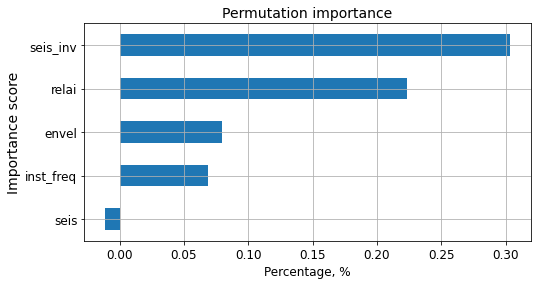

In [66]:
# Feature importance
from machine_learning import feature_importance_plot
feature_importance_plot(model_LR, x_train, y_train, random_state=50)

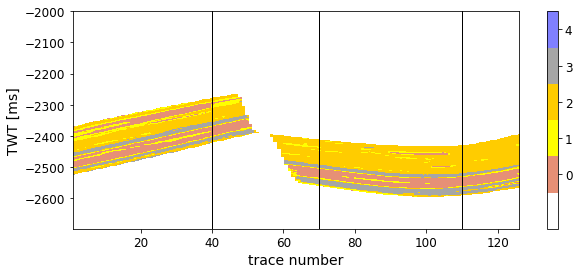

In [67]:
# Plot 2D facies prediction
plot_2D_section(data_file=facies_pred.T, extent_plot=extent_facies,  color_map='facies', number_of_facies=5, list_of_wells=col_3)

In [68]:
facies_class = ['Coarse Sand','Sand','Fine Sand','Shale', 'Carbonate']

              precision    recall  f1-score   support

         0.0       0.72      0.80      0.76      3969
         1.0       0.49      0.25      0.33      3775
         2.0       0.69      0.87      0.77      7088
         3.0       0.68      0.62      0.65      3485
         4.0       0.00      0.00      0.00       185

    accuracy                           0.67     18502
   macro avg       0.52      0.51      0.50     18502
weighted avg       0.65      0.67      0.65     18502



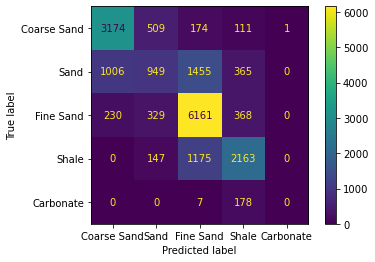

In [69]:
# Classification report and confusion matrix of 2D facies prediction
report_print_LR, f1_score_per_class_LR, count_facies, accuracy_test_LR  = confusion_matrix_prediction(df_facies_comparison, 
                                                                                                   facies_pred, 
                                                                                                   col_number=col_3, 
                                                                                                   facies_class=facies_class)

In [70]:
accuracy_test_LR

0.6727380823694735

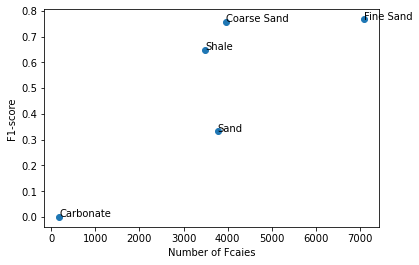

In [71]:
# Plot number of facies VS F1_score
facies_class = ['Coarse Sand', 'Sand', 'Fine Sand', 'Shale', 'Carbonate']
fig, ax = plt.subplots()
ax.scatter(count_facies, f1_score_per_class_LR)

for i, txt in enumerate(facies_class):
    ax.annotate(txt, (count_facies[i], f1_score_per_class_LR[i]))
    
plt.ylabel('F1-score')
plt.xlabel('Number of Fcaies')
plt.show()

In [72]:
f1_score_per_class_LR_ = f1_score_per_class_LR.tolist()
f1_score_per_class_LR_

[0.7576083064804869,
 0.33245752320896826,
 0.7672478206724782,
 0.6485757121439281,
 0.0]

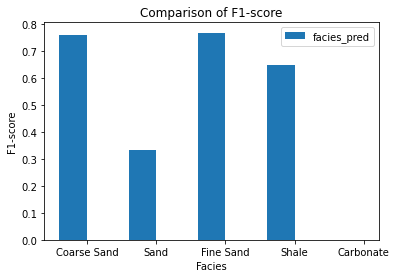

In [73]:
facies_class = ['Coarse Sand','Sand','Fine Sand','Shale', 'Carbonate']
facies_pred = f1_score_per_class_LR_
#facies_actual = fg
  
X_axis = np.arange(len(facies_class))
  
plt.bar(X_axis - 0.2, facies_pred, 0.4, label = 'facies_pred')
#plt.bar(X_axis + 0.2, facies_actual, 0.4, label = 'facies_actual')
  
plt.xticks(X_axis, facies_class)
plt.xlabel("Facies")
plt.ylabel("F1-score")
plt.title("Comparison of F1-score")
plt.legend()
plt.show()

LogReg failed to predict Carbonates

### K-Nearest Neighbor, KNN

In [75]:
# K-Nearest Neighbor, KNN
# Train KNN
model_KNN = neighbors.KNeighborsClassifier()
model_KNN.fit(x_train, y_train)

test_predict = model_KNN.predict(x_test)

In [76]:
# Classification report for Validation set
metrics.confusion_matrix(y_test.values.flatten(), test_predict)
# x=y2_test, y=facies_predict,

print(pd.crosstab(y_test.values.flatten(), test_predict))

print(classification_report(y_test.values.flatten(), test_predict))

col_0  0.0  1.0  2.0  3.0
row_0                    
0.0     21    0    1    0
1.0      0   12    4    0
2.0      0    4   34    1
3.0      0    1    1   17
              precision    recall  f1-score   support

         0.0       1.00      0.95      0.98        22
         1.0       0.71      0.75      0.73        16
         2.0       0.85      0.87      0.86        39
         3.0       0.94      0.89      0.92        19

    accuracy                           0.88        96
   macro avg       0.88      0.87      0.87        96
weighted avg       0.88      0.88      0.88        96



In [77]:
accuracy_score_KNN_valid = accuracy_score_cv(estimator=model_KNN, X=x_train, y=y_train, cv=10)
accuracy_score_KNN_valid

accuracy:  0.8421052631578947


0.8421052631578947

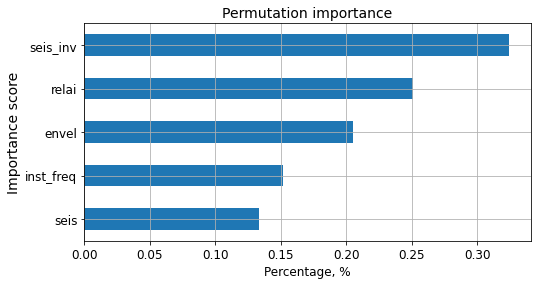

In [78]:
# Feature importance
feature_importance_plot(model_KNN, x_train, y_train, random_state=50)

In [79]:
# Predict 2D facies section from features using trained model
facies_pred, df_facies_comparison = predict_2d_RelAI_Seis_Envel_InstFreq_SeisInv(df_facies=df_facies, 
                                                                                 
                                                                                relai=df_relai_std, 
                                                                                seis=df_seis_std, 
                                                                                envel=df_envel_std,
                                                                                inst_freq=df_inst_freq_std,
                                                                                seis_inv=df_seis_inv_std, 
                                                                                
                                                                                model=model_KNN)
facies_pred

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

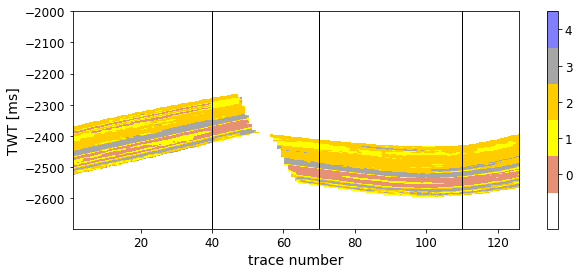

In [80]:
# Plot 2D facies prediction
plot_2D_section(data_file=facies_pred.T, extent_plot=extent_facies, color_map='facies', number_of_facies=5, list_of_wells=col_3)

              precision    recall  f1-score   support

         0.0       0.82      0.72      0.76      3969
         1.0       0.52      0.48      0.50      3775
         2.0       0.76      0.85      0.80      7088
         3.0       0.76      0.81      0.79      3485
         4.0       0.00      0.00      0.00       185

    accuracy                           0.73     18502
   macro avg       0.57      0.57      0.57     18502
weighted avg       0.72      0.73      0.72     18502



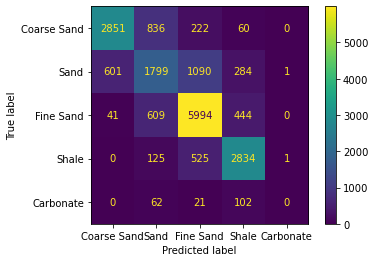

In [81]:
# Classification report and confusion matrix of 2D facies prediction
report_print_KNN, f1_score_per_class_KNN, count_facies, accuracy_test_KNN  = confusion_matrix_prediction(df_facies_comparison, 
                                                                                                         facies_pred, 
                                                                                                         col_number=col_3, 
                                                                                                         facies_class=facies_class)

In [82]:
accuracy_test_KNN

0.72846178791482

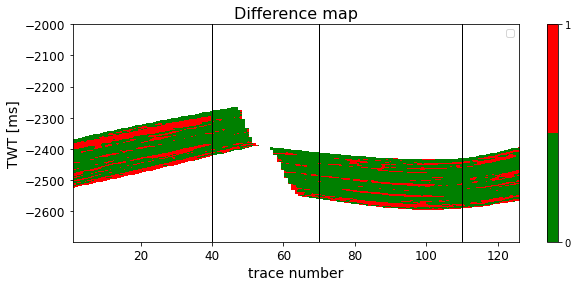

In [83]:
difference_map(df_facies_comparison=df_facies_comparison, facies_predicted=facies_pred, extent=extent_facies, list_of_wells=col_3)

### Support Vector Machines

In [84]:
# Train SVM model
model_SVM = SVC()
model_SVM.fit(x_train, y_train)
test_predict = model_SVM.predict(x_test)

In [85]:
# Classification report for Validation set
metrics.confusion_matrix(y_test.values.flatten(), test_predict)
# x=y2_test, y=facies_predict,

print(pd.crosstab(y_test.values.flatten(), test_predict))

print(classification_report(y_test.values.flatten(), test_predict))

col_0  0.0  1.0  2.0  3.0
row_0                    
0.0     21    0    1    0
1.0      1    9    5    1
2.0      0    2   36    1
3.0      0    1    2   16
              precision    recall  f1-score   support

         0.0       0.95      0.95      0.95        22
         1.0       0.75      0.56      0.64        16
         2.0       0.82      0.92      0.87        39
         3.0       0.89      0.84      0.86        19

    accuracy                           0.85        96
   macro avg       0.85      0.82      0.83        96
weighted avg       0.85      0.85      0.85        96



In [86]:
accuracy_score_SVM_valid = accuracy_score_cv(estimator=model_SVM, X=x_train, y=y_train, cv=10)
accuracy_score_SVM_valid

accuracy:  0.8157894736842104


0.8157894736842104

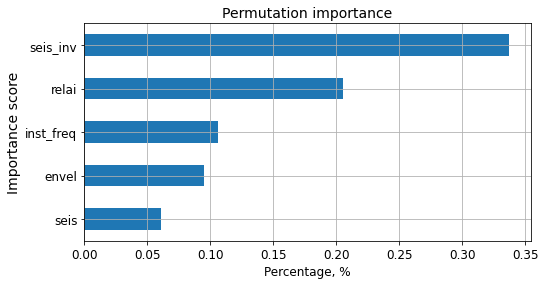

In [87]:
# Feature importance
feature_importance_plot(model_SVM, x_train, y_train, random_state=50)

In [89]:
# Predict 2D facies section from features using trained model
facies_pred, df_facies_comparison = predict_2d_RelAI_Seis_Envel_InstFreq_SeisInv(df_facies=df_facies, 
                                                                                 
                                                                                relai=df_relai_std, 
                                                                                seis=df_seis_std, 
                                                                                envel=df_envel_std,
                                                                                inst_freq=df_inst_freq_std,
                                                                                seis_inv=df_seis_inv_std, 
                                                                                
                                                                                model=model_SVM)
facies_pred

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

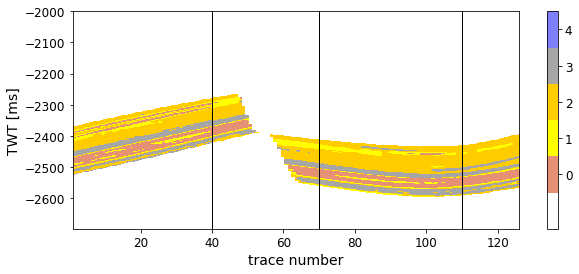

In [90]:
# Plot 2D facies prediction
plot_2D_section(data_file=facies_pred.T, extent_plot=extent_facies, color_map='facies', number_of_facies=5, list_of_wells=col_3)

              precision    recall  f1-score   support

         0.0       0.83      0.77      0.80      3969
         1.0       0.62      0.38      0.47      3775
         2.0       0.76      0.91      0.83      7088
         3.0       0.70      0.80      0.75      3485
         4.0       0.00      0.00      0.00       185

    accuracy                           0.74     18502
   macro avg       0.58      0.57      0.57     18502
weighted avg       0.73      0.74      0.72     18502



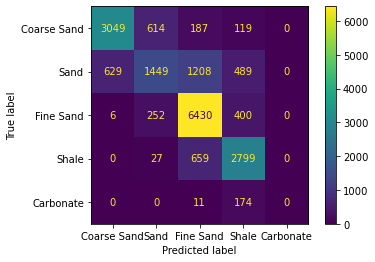

In [91]:
# Classification report and confusion matrix of 2D facies prediction

report_print_SVM, f1_score_per_class_SVM, count_facies, accuracy_test_SVM  = confusion_matrix_prediction(df_facies_comparison, 
                                                                                                         facies_pred, 
                                                                                                         col_number=col_3, 
                                                                                                         facies_class=facies_class)

In [92]:
accuracy_test_SVM

0.7419197924548697

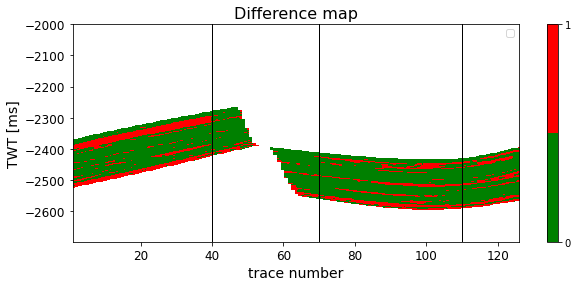

In [93]:
difference_map(df_facies_comparison=df_facies_comparison, facies_predicted=facies_pred, extent=extent_facies, list_of_wells=col_3)

### Random Forest classification

In [94]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

In [95]:
# Train RF model
RF_Classifier_model = RandomForestClassifier(class_weight='balanced').fit(x_train, y_train)

In [96]:
facies_predict_RF = RF_Classifier_model.predict(x_test)

In [97]:
# Classification report for Validation set
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
print(confusion_matrix(y_test, facies_predict_RF))
print(accuracy_score(y_test, facies_predict_RF))
print(classification_report(y_test, facies_predict_RF))

[[20  2  0  0]
 [ 0 12  3  1]
 [ 0  2 37  0]
 [ 0  2  1 16]]
0.8854166666666666
              precision    recall  f1-score   support

         0.0       1.00      0.91      0.95        22
         1.0       0.67      0.75      0.71        16
         2.0       0.90      0.95      0.92        39
         3.0       0.94      0.84      0.89        19

    accuracy                           0.89        96
   macro avg       0.88      0.86      0.87        96
weighted avg       0.89      0.89      0.89        96



In [98]:
accuracy_score_RF_valid = accuracy_score_cv(estimator=RF_Classifier_model, X=x_train, y=y_train, cv=10)
accuracy_score_RF_valid

accuracy:  0.8552631578947368


0.8552631578947368

In [99]:
# Predict 2D facies section from features using trained model
facies_pred, df_facies_comparison = predict_2d_RelAI_Seis_Envel_InstFreq_SeisInv(df_facies=df_facies, 
                                                                                 
                                                                                relai=df_relai_std, 
                                                                                seis=df_seis_std, 
                                                                                envel=df_envel_std,
                                                                                inst_freq=df_inst_freq_std,
                                                                                seis_inv=df_seis_inv_std, 
                                                                                
                                                                                model=RF_Classifier_model)
facies_pred

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

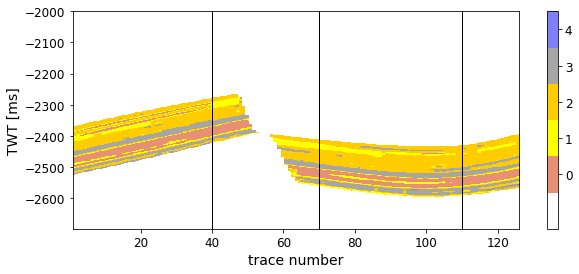

In [100]:
# Plot 2D facies prediction
plot_2D_section(data_file=facies_pred.T, extent_plot=extent_facies, color_map='facies', number_of_facies=5, list_of_wells=col_3)

              precision    recall  f1-score   support

         0.0       0.86      0.77      0.82      3969
         1.0       0.66      0.46      0.54      3775
         2.0       0.76      0.89      0.82      7088
         3.0       0.70      0.80      0.74      3485
         4.0       0.15      0.05      0.08       185

    accuracy                           0.75     18502
   macro avg       0.63      0.59      0.60     18502
weighted avg       0.74      0.75      0.74     18502



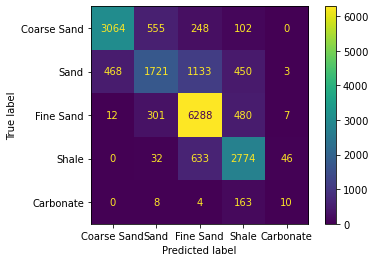

In [101]:
# Classification report and confusion matrix of 2D facies prediction
report_print_RF, f1_score_per_class_RF, count_facies, accuracy_test_RF  = confusion_matrix_prediction(df_facies_comparison, 
                                                                                                         facies_pred, 
                                                                                                         col_number=col_3, 
                                                                                                         facies_class=facies_class)

In [102]:
accuracy_test_RF

0.7489460598854178

#### Difference map

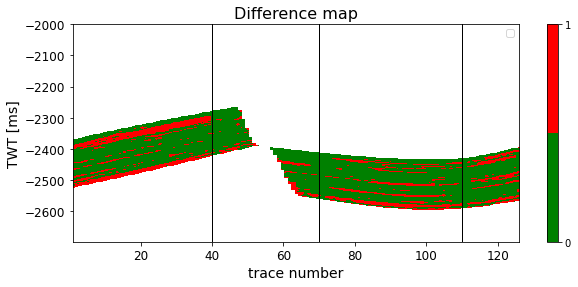

In [103]:
difference_map(df_facies_comparison=df_facies_comparison, facies_predicted=facies_pred, extent=extent_facies, list_of_wells=col_3)

### Neural Network

In [104]:
# # Import libraries

# %pip install tensorflow
# # version is tensorflow-2.11.0

In [105]:
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

In [106]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense

In [107]:
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras import optimizers

In [108]:
from tensorflow.keras.layers import InputLayer

In [109]:
facies_and_features_NN = facies_and_features[['facies', 'relai', 'seis', 'envel', 'inst_freq', 'seis_inv']]
facies_and_features_NN

,facies,relai,seis,envel,inst_freq,seis_inv
273,2.0,0.141887,-0.016197,-1.100501,0.299582,0.032082
274,2.0,0.138053,-0.055543,-1.179386,-0.299656,-0.038751
275,2.0,0.139685,-0.024066,-1.193354,-1.615421,-0.095563
276,2.0,0.156228,0.059349,-0.858970,-2.457742,-0.122351
277,2.0,0.191384,0.163224,-1.164271,-1.256570,-0.110877
...,...,...,...,...,...,...
590,0.0,-0.044963,-0.713418,-0.073123,-0.463554,0.367002
591,1.0,-0.110848,-0.393924,-0.320843,-1.026790,0.350028
592,1.0,-0.152720,-0.264867,0.694972,-2.137490,0.383546
593,3.0,-0.192152,-0.253850,0.989596,-3.586174,0.430658


In [110]:
tf.random.set_seed(124) 
tf.debugging.set_log_device_placement(False)

#### Split the data on train, test and validation

In [111]:
facies_and_features_mixed = facies_and_features_NN.sample(frac=1) # shuffle the rows
facies_and_features_mixed.head(5)

,facies,relai,seis,envel,inst_freq,seis_inv
559,1.0,-0.253634,-2.271543,1.868815,-0.408999,-0.393378
499,3.0,1.924781,0.163224,0.804010,-0.362420,1.450937
546,3.0,2.495403,1.209843,1.650299,-0.841966,2.070327
542,0.0,-0.926218,0.703059,-0.710905,1.096446,-1.072955
516,0.0,-1.442387,1.206695,-0.084742,0.693281,-1.364321


In [124]:
train_set, test_val_set = train_test_split(facies_and_features_mixed, test_size=0.5)

print(train_set.shape)
print(test_val_set.shape)

(238, 6)
(238, 6)


In [125]:
train_set

,facies,relai,seis,envel,inst_freq,seis_inv
580,3.0,1.677503,1.331031,0.302413,1.342702,2.227513
439,2.0,0.204531,0.172667,-1.273544,0.765055,0.146731
542,2.0,1.353682,2.139997,1.958905,-0.861038,1.034290
443,2.0,0.235574,-0.085447,-0.892973,-0.556694,0.256338
522,3.0,1.660053,0.421337,0.564845,-0.077504,1.211047
...,...,...,...,...,...,...
360,3.0,2.192667,-1.043930,1.989448,-0.163470,1.960369
556,2.0,1.083407,-2.474571,1.973542,-0.350577,2.061515
330,2.0,-0.302732,-0.153123,-0.998749,-1.213507,-0.115584
550,3.0,2.747498,-0.200339,1.554536,-0.798219,2.307973


In [126]:
# Split test_val_set on test and validation sets
test_set, val_set = train_test_split(test_val_set, test_size=0.5)
print(test_set.shape)
print(val_set.shape)

(119, 6)
(119, 6)


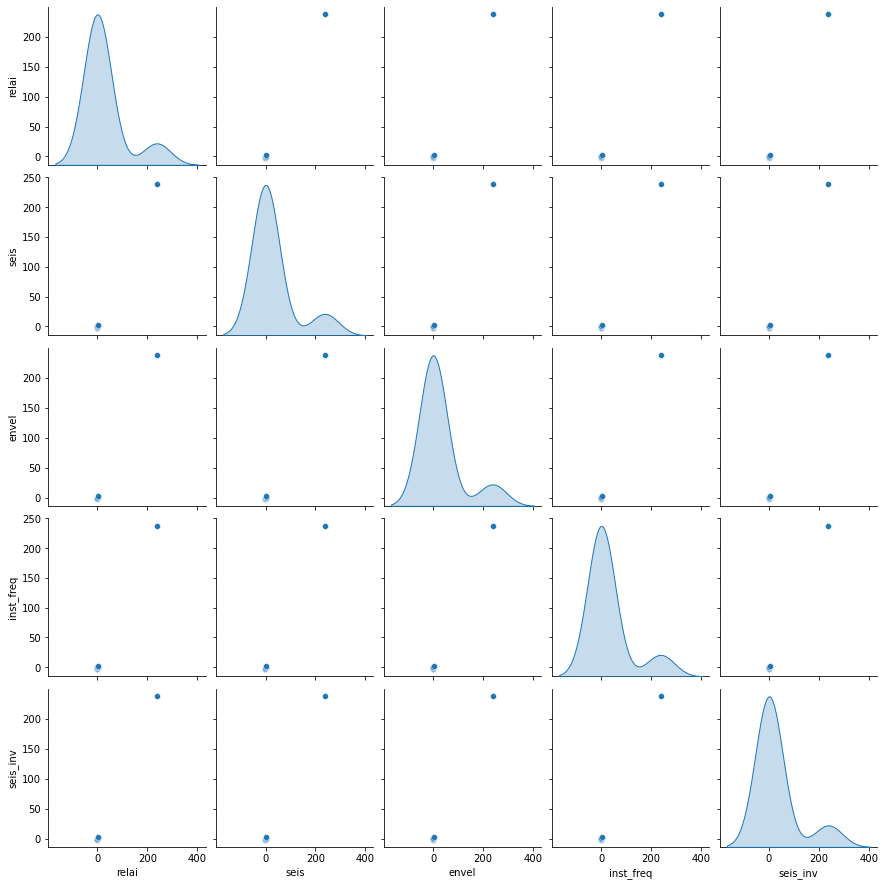

In [127]:
# Plot the relationship between each two variables to spot anything incorrect.
train_stats = train_set.describe()
train_stats.pop('facies')
sns.pairplot(train_stats[train_stats.columns], diag_kind="kde") # or diag_kind='reg'

In [128]:
# Statistics on the train dataset to make sure it is in a good shape. (you may display the same stat for test and validate)
train_stats = train_set.describe()
train_stats.pop("facies")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
relai,238.0,0.050376,1.023103,-1.958511,-0.623656,-0.036227,0.569362,2.756389
seis,238.0,0.004634,1.092684,-3.157628,-0.520620,-0.017771,0.565346,2.840366
envel,238.0,0.065499,1.067977,-1.375995,-0.710938,-0.335325,0.710826,2.691423
inst_freq,238.0,-0.194277,0.847839,-3.301831,-0.608670,-0.214747,0.199937,1.668385
seis_inv,238.0,0.082720,1.010520,-1.857212,-0.637292,0.040860,0.625118,2.312135


In [129]:
# Delete facies column
train_labels1 = train_set.pop('facies')
test_labels1 = test_set.pop('facies')
valid_labels1 = val_set.pop('facies')

In [130]:
train_labels1

580    3.0
439    2.0
542    2.0
443    2.0
522    3.0
      ... 
360    3.0
556    2.0
330    2.0
550    3.0
538    0.0
Name: facies, Length: 238, dtype: float64

In [131]:
train_set

,relai,seis,envel,inst_freq,seis_inv
580,1.677503,1.331031,0.302413,1.342702,2.227513
439,0.204531,0.172667,-1.273544,0.765055,0.146731
542,1.353682,2.139997,1.958905,-0.861038,1.034290
443,0.235574,-0.085447,-0.892973,-0.556694,0.256338
522,1.660053,0.421337,0.564845,-0.077504,1.211047
...,...,...,...,...,...
360,2.192667,-1.043930,1.989448,-0.163470,1.960369
556,1.083407,-2.474571,1.973542,-0.350577,2.061515
330,-0.302732,-0.153123,-0.998749,-1.213507,-0.115584
550,2.747498,-0.200339,1.554536,-0.798219,2.307973


In [132]:
train_labels2 = train_labels1.astype(np.uint8)
train_labels2

valid_labels2 = valid_labels1.astype(np.uint8)
test_labels2 = test_labels1.astype(np.uint8)

In [133]:
# Encode the labeles
train_labels = pd.get_dummies(train_labels1, prefix='Label')
val_labels = pd.get_dummies(valid_labels1, prefix='Label')
test_labels = pd.get_dummies(test_labels1, prefix='Label')



In [134]:
train_labels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 238 entries, 580 to 538
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Label_0.0  238 non-null    uint8
 1   Label_1.0  238 non-null    uint8
 2   Label_2.0  238 non-null    uint8
 3   Label_3.0  238 non-null    uint8
 4   Label_4.0  238 non-null    uint8
dtypes: uint8(5)
memory usage: 3.0 KB


The data is already standartized

Build NN

In [145]:
def NN_model():
    model=Sequential()
    # model.add(InputLayer(input_shape=(train_set.shape[1])))
    model.add(Dense(5, input_shape=(train_set.shape[1],)))   
    # model.add(Dropout(0.1))
    model.add(Dense(10, activation='sigmoid'))                  #input layer
    # model.add(Dropout(0.7))                                       # drop out layer for regularization
    # model.add(Dense(50, activation='softmax'))                      # hidden layer 1
    # model.add(Dense(5, activation='softmax'))                     # hidden layer 2
    model.add(Dense(5, activation='softmax'))                                              # output layer
    # model=Sequential()
    # model.add(Dense(36, input_shape=(train_set.shape[1],)))
    # model.add(Dense(5, activation='sigmoid'))

    learning_rate = 0.01
    optimizer = optimizers.Adam(learning_rate)

    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model
    
Epochs = 500
Batch_size = 100

model = NN_model()
print('Here is a summary of this model: ')
model.summary()

with tf.device('/CPU:0'):
    history = model.fit(
        train_set,
        train_labels,
        batch_size=Batch_size,
        epochs=Epochs,
        verbose=1,
        shuffle=True,
        steps_per_epoch = int(train_set.shape[0]/Batch_size),
        validation_data = (val_set, val_labels))



Here is a summary of this model: 
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 5)                 30        
                                                                 
 dense_10 (Dense)            (None, 10)                60        
                                                                 
 dense_11 (Dense)            (None, 5)                 55        
                                                                 
Total params: 145
Trainable params: 145
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
2/2 [==============================] - 1s 189ms/step - loss: 1.5098 - accuracy: 0.4000 - val_loss: 1.4930 - val_accuracy: 0.3950
Epoch 2/500
2/2 [==============================] - 0s 31ms/step - loss: 1.3913 - accuracy: 0.4710 - val_loss: 1.4487 - val_accuracy: 0.3950
Epoch

In [146]:
print('summary of the results after each epoch: ')
hist_res = pd.DataFrame(history.history)
hist_res['epoch'] = history.epoch
hist_res.tail(10)

summary of the results after each epoch: 


,loss,accuracy,val_loss,val_accuracy,epoch
490,0.211573,0.913043,0.517791,0.840336,490
491,0.354011,0.876812,0.515542,0.840336,491
492,0.275754,0.895000,0.513305,0.848740,492
493,0.291866,0.898551,0.508846,0.848740,493
494,0.277345,0.920290,0.506612,0.848740,494
495,0.287629,0.905000,0.506886,0.848740,495
496,0.303168,0.891304,0.506506,0.848740,496
497,0.244349,0.927536,0.507266,0.857143,497
498,0.265173,0.920000,0.507941,0.857143,498
499,0.235750,0.927536,0.507137,0.848740,499


#### Accuracy for the training set

In [147]:
# from matplotlib import pyplot as plt

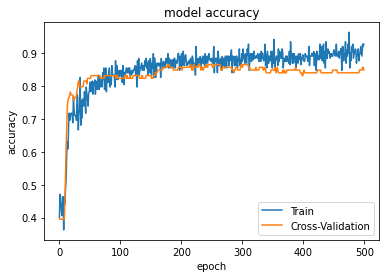

In [148]:

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Cross-Validation'], loc='lower right')
plt.show()

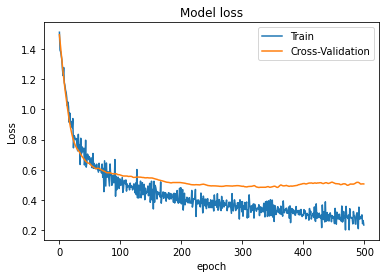

In [149]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Cross-Validation'], loc='upper right')
plt.show()

**Activation:**
Use Sigmoid: it didn't improve the results at all compared with Softmax. 

Relu and Tanh showed bad results

**Optimizer**
Using Adam optimizer is better that SGD

In [150]:
nn_test_prob = model.predict(test_set)
nn_test_prob.shape

4/4 [==============================] - 0s 2ms/step


(119, 5)

In [151]:
test_nn2 = np.array(pd.DataFrame(nn_test_prob).idxmax(axis=1))
test_nn2.shape

(119,)

In [152]:
print(confusion_matrix(test_labels1, test_nn2))
print(accuracy_score(test_labels1, test_nn2))
print(classification_report(test_labels1, test_nn2))

[[24  1  1  0]
 [ 2 14  7  0]
 [ 4  7 37  0]
 [ 0  0  9 13]]
0.7394957983193278
              precision    recall  f1-score   support

         0.0       0.80      0.92      0.86        26
         1.0       0.64      0.61      0.62        23
         2.0       0.69      0.77      0.73        48
         3.0       1.00      0.59      0.74        22

    accuracy                           0.74       119
   macro avg       0.78      0.72      0.74       119
weighted avg       0.76      0.74      0.74       119



#### Facies section prediction

In [153]:
r, c = np.shape(df_facies)
map_facies = np.zeros((r, c))
df_f_comparison = map_facies.copy()
df_f_comparison[:] = np.NaN
map_facies_1 = map_facies.copy()
map_facies_1[:] = np.NaN
empty_list = []

map_facies_2 = np.zeros((r, c))
map_facies_2[:] = np.NaN

map_facies_encoded = np.zeros((r, 5))
map_facies_encoded[:] = np.NaN


facies_encoded = map_facies_encoded.copy()

map_facies.shape

# for every trace (column)
for every_col in range(len(df_facies.columns)):
    new_df = pd.concat([df_relai_std.iloc[:,every_col], 
                        df_seis_std.iloc[:,every_col],
                        df_envel_std.iloc[:,every_col],
                        df_inst_freq_std.iloc[:,every_col],
                        df_seis_inv_std.iloc[:,every_col]]
                        , axis=1)
    
    
    new_df_1 = new_df.dropna(axis=0)
    non_empty_facies = df_facies.iloc[:,every_col].dropna(axis=0)
    facies_encoded[new_df_1.index, :] = model.predict(new_df_1)
    
    facies_encoded_nn = np.array(pd.DataFrame(facies_encoded).idxmax(axis=1))
    # empty_list.append(facies_encoded_nn)
    facies_encoded_nn_1 = facies_encoded_nn.reshape(facies_encoded_nn.shape[0], -1)
    
    # Filter 
    map_facies_1[new_df_1.index, every_col] = facies_encoded_nn_1[new_df_1.index, 0]
    df_f_comparison[new_df_1.index, every_col] = df_facies.iloc[new_df_1.index, every_col]
    
    
        # Filter 
    map_facies_2[non_empty_facies.index, every_col] = map_facies_1[non_empty_facies.index, every_col]
    #df_f_comparison[new_df_1.index, every_col] = df_f_copy.iloc[new_df_1.index, every_col]
    

df_f_comparison


6/6 [==============================] - 0s 1ms/step


array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

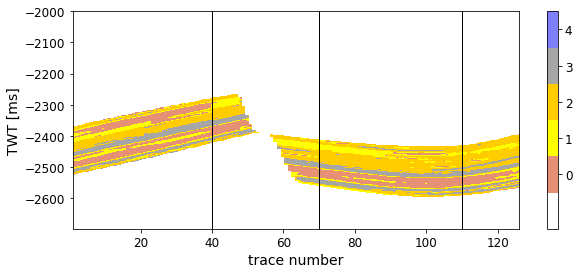

In [154]:
# Plot 2D facies prediction
plot_2D_section(data_file=map_facies_2.T, extent_plot=extent_facies, color_map='facies', number_of_facies=5, list_of_wells=col_3)

              precision    recall  f1-score   support

         0.0       0.66      0.77      0.71      3969
         1.0       0.57      0.41      0.48      3775
         2.0       0.77      0.81      0.79      7088
         3.0       0.73      0.78      0.75      3485
         4.0       0.00      0.00      0.00       185

    accuracy                           0.70     18502
   macro avg       0.55      0.55      0.55     18502
weighted avg       0.69      0.70      0.69     18502



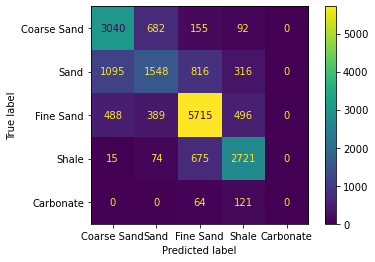

In [155]:
# Classification report and confusion matrix of 2D facies prediction
report_print_NN, f1_score_per_class_NN, count_facies, accuracy_test_NN  = confusion_matrix_prediction(df_f_comparison, 
                                                                                                         map_facies_2, 
                                                                                                         col_number=col_3, 
                                                                                                         facies_class=facies_class)

In [156]:
accuracy_test_NN

0.703923900118906

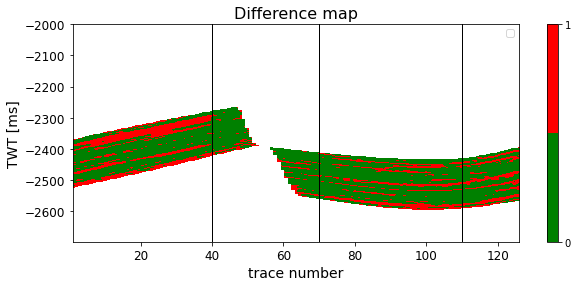

In [157]:
difference_map(df_facies_comparison=df_f_comparison, facies_predicted=map_facies_2, extent=extent_facies, list_of_wells=col_3)

## Compare res

In [158]:
# Compare accuracies
list_of_accuracies = [accuracy_test_LR, accuracy_test_KNN, accuracy_test_SVM, accuracy_test_RF, accuracy_test_NN]
list_of_accuracies_100 = [i*100 for i in list_of_accuracies]


In [159]:
np.max(list_of_accuracies)

0.7489460598854178

In [160]:
accuracy_test_RF

0.7489460598854178

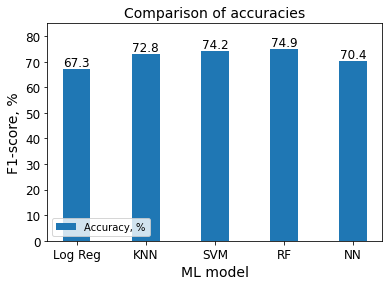

In [161]:
models_used = ['Log Reg','KNN','SVM','RF', 'NN']
fig, ax = plt.subplots(figsize=(6, 4))

  
X_axis = np.arange(len(models_used))
  
abc = plt.bar(X_axis, list_of_accuracies_100, 0.4, label = 'Accuracy, %')
#plt.bar(X_axis + 0.2, facies_actual, 0.4, label = 'facies_actual')
ax.bar_label(abc, fmt='%.1f', fontsize=12)
plt.xticks(X_axis, models_used, fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("ML model", fontsize=14)
plt.ylabel("F1-score, %", fontsize=14)
plt.title("Comparison of accuracies", fontsize=14)
plt.legend(loc='lower left')
plt.ylim(0, 85)
plt.show()

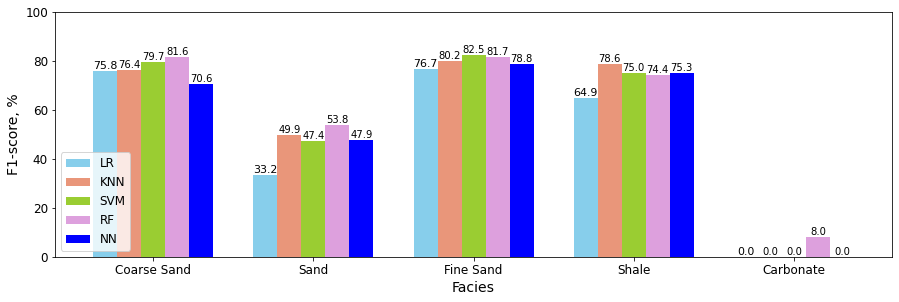

In [162]:
# freq_class = ['Ricker','Ormsby_10_60','Ormsby_10_80','Ormsby_10_100']
facies_class = ['Coarse Sand','Sand','Fine Sand','Shale', 'Carbonate']
X_axis = np.arange(len(facies_class))
#plt.figure(figsize=(11,6))

fig, ax = plt.subplots(figsize=(15, 4.5))
  
bar1 = plt.bar(X_axis-0.3, f1_score_per_class_LR*100, 0.15, label = 'LR', color='skyblue')
bar2 = plt.bar(X_axis-0.15, f1_score_per_class_KNN*100, 0.15, label = 'KNN', color='darksalmon')
bar3 = plt.bar(X_axis, f1_score_per_class_SVM*100, 0.15, label = 'SVM', color='yellowgreen')
bar4 = plt.bar(X_axis+0.15, f1_score_per_class_RF*100, 0.15, label = 'RF', color='plum')
bar5 = plt.bar(X_axis+0.3, f1_score_per_class_NN*100, 0.15, label = 'NN', color='blue')


ax.bar_label(bar1, fmt='%.1f', fontsize=11)
ax.bar_label(bar2, fmt='%.1f')
ax.bar_label(bar3, fmt='%.1f')
ax.bar_label(bar4, fmt='%.1f')
ax.bar_label(bar5, fmt='%.1f')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)  
plt.xticks(X_axis, facies_class)
plt.xlabel("Facies", fontsize=14)
plt.ylabel("F1-score, %", fontsize=14)
#plt.title("Comparison of different Freq")
plt.legend(loc='lower left',fontsize=12)
plt.ylim(0, 100)
plt.show()

# Random SearchCV and GridSearcCV for Random Forest

In [262]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt','log2']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 1000,10)]

# Minimum number of samples required to split a node
min_samples_split = [1, 3, 4, 5, 7, 9]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4,6,8]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
              'criterion':['entropy','gini']}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [10, 120, 230, 340, 450, 560, 670, 780, 890, 1000], 'min_samples_split': [1, 3, 4, 5, 7, 9], 'min_samples_leaf': [1, 2, 4, 6, 8], 'criterion': ['entropy', 'gini']}


In [263]:
RF_Classifier = RandomForestClassifier(class_weight='balanced')
RF_Classifier_rf_searc_cv = RandomizedSearchCV(estimator=RF_Classifier, 
                                                param_distributions=random_grid,
                                                n_iter=100, cv=3,
                                                verbose=2,
                                                random_state=100,
                                                n_jobs=-1)


In [264]:
RF_Classifier_rf_searc_cv.fit(x_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(class_weight='balanced'),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'criterion': ['entropy', 'gini'],
                                        'max_depth': [10, 120, 230, 340, 450,
                                                      560, 670, 780, 890,
                                                      1000],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4, 6, 8],
                                        'min_samples_split': [1, 3, 4, 5, 7, 9],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=100, verbo

In [265]:
# We got best parameters of the model using RandomSearchCV
RF_Classifier_rf_searc_cv.best_params_

{'n_estimators': 400,
 'min_samples_split': 4,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 890,
 'criterion': 'entropy'}

In [266]:
# Now we can use these parameters for predicting our model
best_randomsearchCV_model_RF_Classifier = RF_Classifier_rf_searc_cv.best_estimator_
best_randomsearchCV_model_RF_Classifier

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=890, min_samples_split=4, n_estimators=400)

In [267]:
facies_predict_RF_randsearcCV = best_randomsearchCV_model_RF_Classifier.predict(x_test)

print(confusion_matrix(y_test,facies_predict_RF_randsearcCV))

print("Accuracy Score {}".format(accuracy_score(y_test,facies_predict_RF_randsearcCV)))
print("Classification report: {}".format(classification_report(y_test,facies_predict_RF_randsearcCV)))

[[20  2  0  0]
 [ 0 13  3  0]
 [ 0  2 36  1]
 [ 0  1  1 17]]
Accuracy Score 0.8958333333333334
Classification report:               precision    recall  f1-score   support

         0.0       1.00      0.91      0.95        22
         1.0       0.72      0.81      0.76        16
         2.0       0.90      0.92      0.91        39
         3.0       0.94      0.89      0.92        19

    accuracy                           0.90        96
   macro avg       0.89      0.88      0.89        96
weighted avg       0.90      0.90      0.90        96



In [268]:
accuracy_score_RF = accuracy_score_cv(estimator=best_randomsearchCV_model_RF_Classifier, X=x_train, y=y_train, cv=10)
accuracy_score_RF


accuracy:  0.8578947368421053


0.8578947368421053

In [306]:
facies_pred, df_facies_comparison = predict_2d_RelAI_Seis_Envel_InstFreq_SeisInv(df_facies=df_facies, 
                                                                                 
                                                                                relai=df_relai_std, 
                                                                                seis=df_seis_std, 
                                                                                envel=df_envel_std,
                                                                                inst_freq=df_inst_freq_std,
                                                                                seis_inv=df_seis_inv_std, 
                                                                                
                                                                                model=best_randomsearchCV_model_RF_Classifier)
facies_pred

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

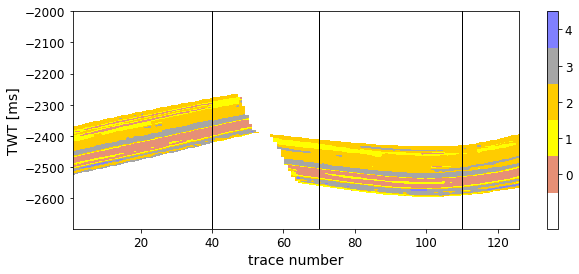

In [307]:
plot_2D_section(data_file=facies_pred.T, extent_plot=extent_facies, color_map='facies', number_of_facies=5, list_of_wells=col_3)

              precision    recall  f1-score   support

         0.0       0.87      0.77      0.82      3969
         1.0       0.66      0.49      0.56      3775
         2.0       0.78      0.88      0.83      7088
         3.0       0.69      0.79      0.74      3485
         4.0       0.14      0.11      0.13       185

    accuracy                           0.75     18502
   macro avg       0.63      0.61      0.61     18502
weighted avg       0.75      0.75      0.75     18502



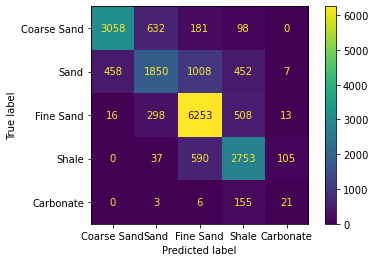

In [308]:
report_print_RF_rands, f1_score_per_class_RF_rands, count_facies, accuracy_test_RF_rands  = confusion_matrix_prediction(df_facies_comparison, 
                                                                                                         facies_pred, 
                                                                                                         col_number=col_3, 
                                                                                                         facies_class=facies_class)

In [309]:
accuracy_test_RF_rands

0.7531618203437466

In [310]:
accuracy_test_RF


0.7481353367203546

#### Difference map

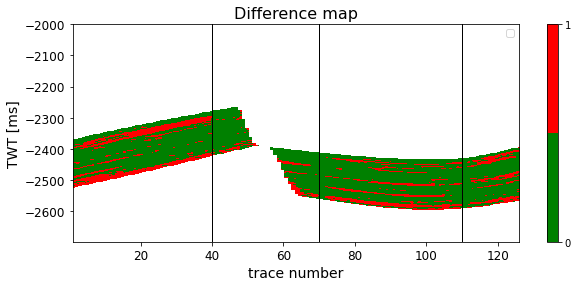

In [311]:
difference_map(df_facies_comparison=df_facies_comparison, facies_predicted=facies_pred, extent=extent_facies, list_of_wells=col_3)

### GridSearchCV

In [275]:
RF_Classifier_rf_searc_cv.best_params_

{'n_estimators': 400,
 'min_samples_split': 4,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 890,
 'criterion': 'entropy'}

In [276]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'criterion': [RF_Classifier_rf_searc_cv.best_params_['criterion']],
    'max_depth': [RF_Classifier_rf_searc_cv.best_params_['max_depth']],
    'max_features': [RF_Classifier_rf_searc_cv.best_params_['max_features']],
    'min_samples_leaf': [RF_Classifier_rf_searc_cv.best_params_['min_samples_leaf'], 
                         RF_Classifier_rf_searc_cv.best_params_['min_samples_leaf']+2, 
                         RF_Classifier_rf_searc_cv.best_params_['min_samples_leaf'] + 3],
    'min_samples_split': [RF_Classifier_rf_searc_cv.best_params_['min_samples_split'] - 2,
                          RF_Classifier_rf_searc_cv.best_params_['min_samples_split'] - 1,
                          RF_Classifier_rf_searc_cv.best_params_['min_samples_split'], 
                          RF_Classifier_rf_searc_cv.best_params_['min_samples_split'] +1,
                          RF_Classifier_rf_searc_cv.best_params_['min_samples_split'] + 2],
    'n_estimators': [RF_Classifier_rf_searc_cv.best_params_['n_estimators'] - 200, 
                    RF_Classifier_rf_searc_cv.best_params_['n_estimators'] - 100, 
                     RF_Classifier_rf_searc_cv.best_params_['n_estimators'], 
                     RF_Classifier_rf_searc_cv.best_params_['n_estimators'] + 100, 
                     RF_Classifier_rf_searc_cv.best_params_['n_estimators'] + 200]
}

print(param_grid)

{'criterion': ['entropy'], 'max_depth': [890], 'max_features': ['auto'], 'min_samples_leaf': [1, 3, 4], 'min_samples_split': [2, 3, 4, 5, 6], 'n_estimators': [200, 300, 400, 500, 600]}


In [277]:
#### Fit the grid_search to the data
RF_model = RandomForestClassifier(class_weight='balanced')
grid_search=GridSearchCV(estimator=RF_model, param_grid=param_grid,cv=10,n_jobs=-1,verbose=2)


In [278]:
grid_search.fit(x_train,y_train)

Fitting 10 folds for each of 75 candidates, totalling 750 fits


GridSearchCV(cv=10, estimator=RandomForestClassifier(class_weight='balanced'),
             n_jobs=-1,
             param_grid={'criterion': ['entropy'], 'max_depth': [890],
                         'max_features': ['auto'],
                         'min_samples_leaf': [1, 3, 4],
                         'min_samples_split': [2, 3, 4, 5, 6],
                         'n_estimators': [200, 300, 400, 500, 600]},
             verbose=2)

In [279]:
grid_search.best_estimator_

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=890, n_estimators=300)

In [280]:
best_grid=grid_search.best_estimator_
best_grid


RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=890, n_estimators=300)

In [281]:
# best_grid_saved = RandomForestClassifier(criterion='entropy', max_depth=1000, max_features='sqrt',
#                        n_estimators=1900)

In [282]:
y_pred=best_grid.predict(x_test)
print(confusion_matrix(y_test,y_pred))
print("Accuracy Score {}".format(accuracy_score(y_test,y_pred)))
print("Classification report: {}".format(classification_report(y_test,y_pred)))

[[20  2  0  0]
 [ 0 12  4  0]
 [ 0  2 37  0]
 [ 0  1  1 17]]
Accuracy Score 0.8958333333333334
Classification report:               precision    recall  f1-score   support

         0.0       1.00      0.91      0.95        22
         1.0       0.71      0.75      0.73        16
         2.0       0.88      0.95      0.91        39
         3.0       1.00      0.89      0.94        19

    accuracy                           0.90        96
   macro avg       0.90      0.88      0.88        96
weighted avg       0.90      0.90      0.90        96



In [283]:
accuracy_score_RF_grid = accuracy_score_cv(estimator=best_grid, X=x_train, y=y_train, cv=10)
accuracy_score_RF_grid


accuracy:  0.8526315789473685


0.8526315789473685

In [294]:
facies_pred, df_facies_comparison = predict_2d_RelAI_Seis_Envel_InstFreq_SeisInv(df_facies=df_facies, 
                                                                                 
                                                                                relai=df_relai_std, 
                                                                                seis=df_seis_std, 
                                                                                envel=df_envel_std,
                                                                                inst_freq=df_inst_freq_std,
                                                                                seis_inv=df_seis_inv_std, 
                                                                                
                                                                                model=best_grid)
facies_pred

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

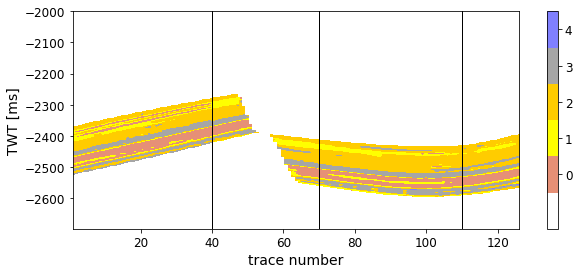

In [295]:
plot_2D_section(data_file=facies_pred.T, extent_plot=extent_facies, color_map='facies', number_of_facies=5, list_of_wells=col_3)

              precision    recall  f1-score   support

         0.0       0.86      0.77      0.81      3969
         1.0       0.65      0.49      0.56      3775
         2.0       0.78      0.89      0.83      7088
         3.0       0.70      0.80      0.75      3485
         4.0       0.16      0.05      0.08       185

    accuracy                           0.76     18502
   macro avg       0.63      0.60      0.61     18502
weighted avg       0.75      0.76      0.75     18502



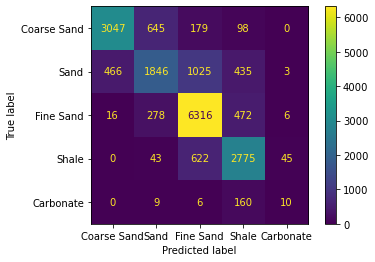

In [296]:
report_print_RF_grid, f1_score_per_class_RF_grid, count_facies, accuracy_test_RF_grid  = confusion_matrix_prediction(df_facies_comparison, 
                                                                                                         facies_pred, 
                                                                                                         col_number=col_3, 
                                                                                                         facies_class=facies_class)

#### Difference map

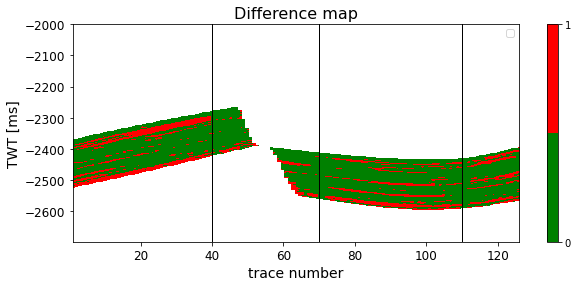

In [300]:
difference_map(df_facies_comparison=df_facies_comparison, facies_predicted=facies_pred, extent=extent_facies, list_of_wells=col_3)

## Compare res

In [312]:
# Compare accuracies
list_of_accuracies = [accuracy_test_RF, accuracy_test_RF_rands, accuracy_test_RF_grid]
list_of_accuracies_100 = [i*100 for i in list_of_accuracies]


In [313]:
np.max(list_of_accuracies)

0.7563506647929954

In [314]:
accuracy_test_RF

0.7481353367203546

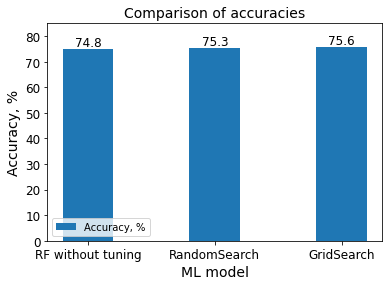

In [315]:
hyperparam_tuning = ['RF without tuning','RandomSearch','GridSearch']
fig, ax = plt.subplots(figsize=(6, 4))

  
X_axis = np.arange(len(hyperparam_tuning))
  
abc = plt.bar(X_axis, list_of_accuracies_100, 0.4, label = 'Accuracy, %')
#plt.bar(X_axis + 0.2, facies_actual, 0.4, label = 'facies_actual')
ax.bar_label(abc, fmt='%.1f', fontsize=12)


plt.xticks(X_axis, hyperparam_tuning, fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("ML model", fontsize=14)
plt.ylabel("Accuracy, %", fontsize=14)
plt.title("Comparison of accuracies", fontsize=14)
plt.legend(loc='lower left')
plt.ylim(0, 85)
plt.show()

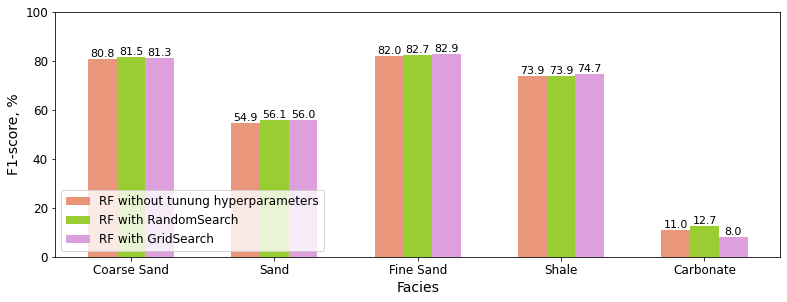

In [318]:
# freq_class = ['Ricker','Ormsby_10_60','Ormsby_10_80','Ormsby_10_100']
facies_class = ['Coarse Sand','Sand','Fine Sand','Shale', 'Carbonate']
X_axis = np.arange(len(facies_class))
#plt.figure(figsize=(11,6))

fig, ax = plt.subplots(figsize=(13, 4.5))
  
bar2 = plt.bar(X_axis-0.2, f1_score_per_class_RF*100, 0.2, label = 'RF without tunung hyperparameters', color='darksalmon')
bar3 = plt.bar(X_axis, f1_score_per_class_RF_rands*100, 0.2, label = 'RF with RandomSearch', color='yellowgreen')
bar4 = plt.bar(X_axis+0.2, f1_score_per_class_RF_grid*100, 0.2, label = 'RF with GridSearch', color='plum')



ax.bar_label(bar2, fmt='%.1f', fontsize=11)
ax.bar_label(bar3, fmt='%.1f', fontsize=11)
ax.bar_label(bar4, fmt='%.1f', fontsize=11)


plt.xticks(fontsize=12)
plt.yticks(fontsize=12)  
plt.xticks(X_axis, facies_class)
plt.xlabel("Facies", fontsize=14)
plt.ylabel("F1-score, %", fontsize=14)
#plt.title("Comparison of different Freq")
plt.legend(loc='lower left',fontsize=12)
plt.ylim(0, 100)
plt.show()